In [1]:
import numpy as np
import matplotlib.pyplot as plt

import batman
import juliet
import emcee
import zeus

/Users/nespinoza/miniconda2/envs/newen/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## 1. Data downloads and checks

All right, let's first use `juliet` to get the data for TOI-141b:

In [2]:
t,f,ferr  = juliet.get_TESS_data('https://archive.stsci.edu/hlsps/tess-data-alerts/'+\
                              'hlsp_tess-data-alerts_tess_phot_00403224672-'+\
                              's01_tess_v1_lc.fits')

Let's plot the data:

<ErrorbarContainer object of 3 artists>

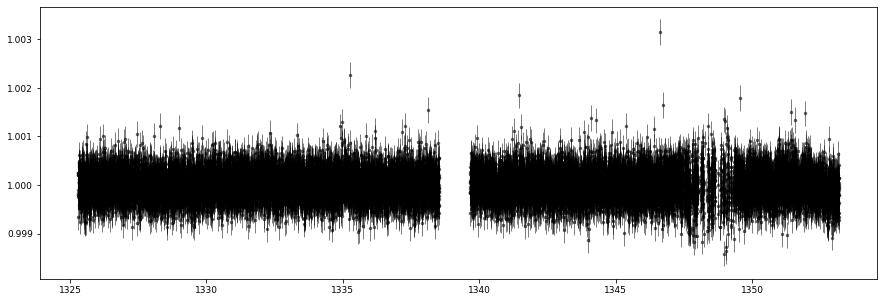

In [3]:
plt.figure(figsize=(15,5))
plt.errorbar(t,f,ferr,fmt='.',alpha=0.5, color='black',elinewidth=1)

Okay. Just to make sure, let's phase the data to the time of transit:

(0.9985, 1.001)

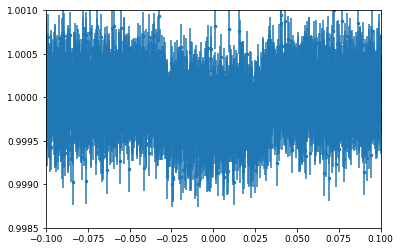

In [4]:
P, t0 = 1.008035, 1379.97043
phases = juliet.utils.get_phases(t,P,t0)

plt.errorbar(phases, f, ferr,fmt='.')
plt.xlim(-0.1,0.1)
plt.ylim(0.9985,1.001)

Cool! Transit is there. Let's fit it next.

## 2. Fitting the transit with `zeus`

All right, let's first define the transit model:

In [5]:
# Transform times to float64 --- batman loves those:
t = t.astype('float64')

# Define params object and initialize the transit model object:
params = batman.TransitParams()
params.t0 = 0.0   # time of inferior conjunction
params.per = 1.0  # orbital period (days)
params.a = 3.6    # semi-major axis (in units of stellar radii)
params.rp = 0.1   # rp/rs
params.inc = 90.  # orbital inclination (in degrees)
params.ecc = 0.   # eccentricity
params.w = 90.    # longitude of periastron (in degrees) p
params.limb_dark = 'quadratic' # limb darkening profile to use
params.u = [0.2,0.3] # limb darkening coefficients
tmodel = batman.TransitModel(params, t)

# Define function that returns transit model:
def get_transit_model(t0, per, a, rp, inc, u1, u2):
    params.t0 = t0   # time of inferior conjunction
    params.per = per  # orbital period (days)
    params.a = a   # semi-major axis (in units of stellar radii)
    params.rp = rp   # rp/rs
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = 0.   # eccentricity
    params.w = 90.    # longitude of periastron (in degrees) p
    params.limb_dark = 'quadratic' # limb darkening profile to use
    params.u = [u1, u2] # limb darkening coefficients
    return tmodel.light_curve(params)

All right, let's now define the `zeus` log-probability. To this end, define the log-prior and log-likelihood for the parameters to be fitted:

In [6]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    t0, per, a, rp, b, u1, u2, oot_flux = theta

    # Set uniform priors on a, rp, inc, u1, u2, and sigma_w:
    if (a<0 or a>10) or (rp<0 or rp>0.1) or (b<0 or b>1) or (u1<0 or u1>1) or (u2<0 or u2>1):
        return -np.inf

    # Gaussian prior on t0, per and oot_flux. First t0:
    mmu = 1379.97043     # mean of the Gaussian prior
    msigma = 0.1 # standard deviation of the Gaussian prior
    lp -= 0.5*((t0 - mmu)/msigma)**2
    
    # Now period:
    mmu = 1.008035     # mean of the Gaussian prior
    msigma = 0.1 # standard deviation of the Gaussian prior
    lp -= 0.5*((per - mmu)/msigma)**2 
    
    # oot_flux:
    mmu = 0.0     # mean of the Gaussian prior
    msigma = 1e-3 # standard deviation of the Gaussian prior
    lp -= 0.5*((oot_flux - mmu)/msigma)**2 

    return lp

def loglike(theta):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    t0, per, a, rp, b, u1, u2, oot_flux = theta

    # evaluate the model
    md = get_transit_model(t0, per, a, rp, np.arccos(b/a) * (180./np.pi), u1, u2) + oot_flux

    # return the log likelihood
    return -0.5 * np.sum(((md - f)/ferr)**2)

def logpost(theta):
    '''The natural logarithm of the posterior.'''
    lp = logprior(theta)
    if lp != -np.inf:
        return logprior(theta) + loglike(theta)
    else:
        return -np.inf

And sample with `zeus`:

In [7]:
ndim = 8 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 50 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 2000 # Number of steps/iterations.

# Define starting points for the walkers:
initial_vector = np.array([1379.97043, 1.008035, 3.9, 0.014, 0.67, 0.34, 0.063, 0.0])
start = np.random.randn(nwalkers, ndim)*1e-4
start += initial_vector

Plot where in the model where walkers are starting from:

(0.9985, 1.001)

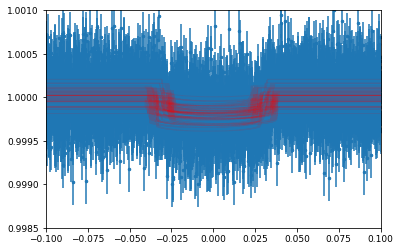

In [8]:
idx = np.argsort(phases)
plt.errorbar(phases, f, ferr,fmt='.',zorder=1)
for i in range(nwalkers):

    t0, per, a, rp, b, u1, u2, oot_flux  = start[i,:]
    model = get_transit_model(t0,per, a, rp, np.arccos(b/a) * (180./np.pi), u1, u2) + oot_flux
    plt.plot(phases[idx], model[idx],'r-',zorder=2,lw=1, alpha =0.1)
plt.xlim(-0.1,0.1)
plt.ylim(0.9985,1.001)

That's pretty good. Let's now sample:

In [9]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 50 walkers...
Sampling progress :  36%|███▌      | 716/2000 [03:13<06:10,  3.46it/s]

RuntimeError: Number of contractions exceeded maximum limit! 
Make sure that the pdf is well-defined. 
Otherwise increase the maximum limit (maxiter=10^4 by default).

Let's check the chains:

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)

Flatten chain; discard first half of samples. Don't apply thinning:

In [ ]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//2)


# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=['t0', 'per', 'a', 'rp', 'b', 'u1', 'u2', 'oot_flux'], \
                            truth=[1379.97043, 1.008035, 3.927, 0.01453, 0.675, 0.34, 0.063, 0.0]);

Let's plot the posterior of `rp` and `b`; plot quantiles on top:

In [ ]:
t0, per, a, rp, b, u1, u2, oot_flux = chain.T

In [ ]:
bmedian, bup, bdown = juliet.utils.get_quantiles(b)
rpmedian, rpup, rpdown = juliet.utils.get_quantiles(rp)

plt.plot(b, rp,'.', alpha = 0.5,zorder=1)
plt.errorbar(bmedian,rpmedian, \
             xerr=np.array([[bup-bmedian,bmedian-bdown]]).T, \
             yerr=np.array([[rpup-rpmedian,rpmedian-rpdown]]).T,fmt='o',zorder=2)
plt.xlabel('b')
plt.ylabel('rp')

In [ ]:
print(bmedian, bup-bmedian,bmedian-bdown)
print(rpmedian, rpup-rpmedian,rpmedian-rpdown)

## Fitting the transit with `juliet` via Nested Sampling

Let's do the same fit, but using `juliet`'s nested sampling capabilities. In particular, we'll use `MultiNest` --- for which this problem is an extremely easy one to sample from --- so we can have a posterior "ground truth" to compare against. Let's define the priors:

In [16]:
priors = {}

# Name of the parameters to be fit:
prms = ['P_p1','t0_p1','p_p1','b_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distributions:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'uniform', 'fixed', 'normal', 'fixed']

# Hyperparameters1.0
hyperps = [[1.0,0.1], [1379.97043,0.1], [0.,0.1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [0.,10.], 1.0, [0.,0.1], 1e-6]

# Populate the priors dictionary:
for param, dist, hyperp in zip(prms, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

Set dataset in `juliet` format:

In [17]:
times, fluxes, fluxes_err = {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_err['TESS'] = t, f ,ferr

Fit:

In [18]:
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, yerr_lc = fluxes_err, \
                      out_folder = 'multinest-fit')

In [19]:
results = dataset.fit()

  analysing data from multinest-fit/jomnest_.txt


Let's plot the posterior for `rp` and `b` for the `emcee` fit:

Text(0, 0.5, 'rp')

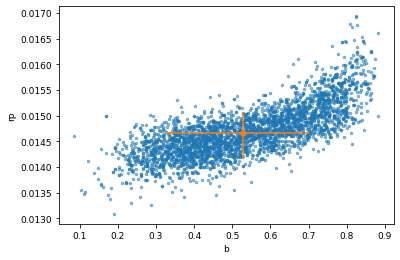

In [20]:
mn_bmedian, mn_bup, mn_bdown = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['b_p1'])
mn_rpmedian, mn_rpup, mn_rpdown = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['p_p1'])

plt.plot(results.posteriors['posterior_samples']['b_p1'], \
         results.posteriors['posterior_samples']['p_p1'], \
         '.', alpha = 0.5,zorder=1)
plt.errorbar(mn_bmedian, mn_rpmedian, \
             xerr=np.array([[mn_bup-mn_bmedian,mn_bmedian-mn_bdown]]).T, \
             yerr=np.array([[mn_rpup-mn_rpmedian,mn_rpmedian-mn_rpdown]]).T,fmt='o',zorder=2)
plt.xlabel('b')
plt.ylabel('rp')

That actually looks much better than `zeus`; and the posterior is totally consistent with the paper posterior.

The only difference between our fit above and the fit done with `zeus` is that we fitted for the transformed limb-darkening coefficients (`q1`, `q2` instead of the direct limb-darkening coefficients we used for the `zeus` fit, in which we fitted for `u1` and `u2`), so in theory a smaller prior. Let's fit now with `emcee` using the same likelihood and prior we used for `zeus` to have a 1-to-1 comparison.

## `emcee` transit fits, _not_ through juliet

All right, let's get to it:

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost) # Initialise the sampler
sampler.run_mcmc(start, nsteps, progress=True) # Run sampling


 19%|█▉        | 383/2000 [00:18<01:08, 23.54it/s]


 42%|████▏     | 836/2000 [00:37<00:50, 22.97it/s]


 64%|██████▍   | 1283/2000 [00:55<00:32, 22.19it/s]


 86%|████████▋ | 1725/2000 [01:15<00:11, 23.35it/s]


100%|██████████| 2000/2000 [01:26<00:00, 23.04it/s]


State([[1.37996453e+03 1.00788091e+00 5.10822475e+00 1.44481333e-02
  1.97953658e-01 1.08847662e-01 4.18453935e-01 1.31567443e-05]
 [1.37996598e+03 1.00792747e+00 5.07224120e+00 1.40477131e-02
  1.33448635e-01 1.21715822e-01 6.76284066e-01 1.60548894e-05]
 [1.37996349e+03 1.00784456e+00 5.23590926e+00 1.42908355e-02
  1.18109692e-01 1.60339778e-01 3.78882405e-01 1.65523365e-05]
 [1.37996568e+03 1.00788444e+00 3.98123023e+00 1.46132902e-02
  6.80999860e-01 2.83105118e-02 2.30430509e-01 1.38717568e-05]
 [1.37997004e+03 1.00803091e+00 5.22406229e+00 1.40254281e-02
  3.23927645e-01 2.83456220e-01 1.24087140e-01 1.40477571e-05]
 [1.37996690e+03 1.00795389e+00 2.58495388e+00 1.66882989e-02
  8.91180225e-01 1.53488304e-01 4.06403451e-01 1.64223560e-05]
 [1.37996605e+03 1.00790210e+00 3.79232541e+00 1.49555188e-02
  7.01516150e-01 1.74365707e-01 6.25657189e-01 2.02966418e-05]
 [1.37996579e+03 1.00790941e+00 3.99904852e+00 1.43120514e-02
  6.26697372e-01 4.64447769e-01 2.66829363e-01 1.51081331

In [11]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
emcee_chain = sampler.get_chain(flat=True, discard=nsteps//2)

In [12]:
emcee_t0, emcee_per, emcee_a, emcee_rp, emcee_b, emcee_u1, emcee_u2, emcee_oot_flux = emcee_chain.T

Text(0, 0.5, 'rp')

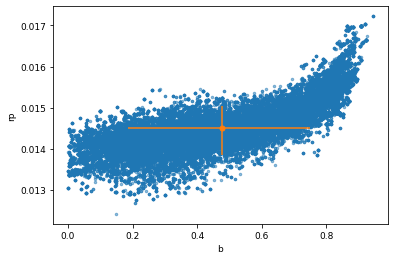

Sampling progress :  36%|███▌      | 716/2000 [07:10<12:52,  1.66it/s]


In [14]:
bmedian, bup, bdown = juliet.utils.get_quantiles(emcee_b)
rpmedian, rpup, rpdown = juliet.utils.get_quantiles(emcee_rp)

plt.plot(emcee_b, emcee_rp,'.', alpha = 0.5,zorder=1)
plt.errorbar(bmedian,rpmedian, \
             xerr=np.array([[bup-bmedian,bmedian-bdown]]).T, \
             yerr=np.array([[rpup-rpmedian,rpmedian-rpdown]]).T,fmt='o',zorder=2)
plt.xlabel('b')
plt.ylabel('rp')

The posterior looks very similar to that of `juliet` --- which is basically "good". Let's plot all of them on the same plot:

NameError: name 'results' is not defined

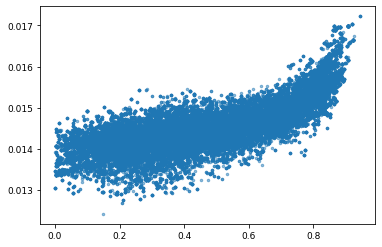

In [15]:
plt.plot(emcee_b, emcee_rp,'.', alpha = 0.5,zorder=1, label = 'emcee')
plt.plot(results.posteriors['posterior_samples']['b_p1'], \
         results.posteriors['posterior_samples']['p_p1'], \
         '.', alpha = 0.5,zorder=3, label='multinest (juliet)')
plt.plot(b, rp,'.', alpha = 0.5,zorder=2,label='zeus')
plt.legend()